By [Kevin Michalewicz](https://kevinmichalewicz.com) on Jan 2025

This notebook discusses interpretability in the context of LLM-GCN.

In [1]:
# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from gcn_bf.utils.biology_utils import bootstrap_test, count_consecutive_secondary, is_in_cdr, get_epitope_members, get_paratope_members, get_antigen_only, get_variable_region_only, preprocess_interpretability
from gcn_bf.utils.torch_utils import load_pickle
from gcn_bf.utils.plot_utils import boxplot_delta_graph, plot_consecutive_secondary, plot_prediction_errors

/Users/kevinmicha/anaconda3/envs/gcn-bagpype/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pre-processing

In [2]:
# Getting test set indices
data_path = '../data/'
interpretability_path = 'interpretability_files/'
test_indices = np.load(data_path+'test_indices.npy')
pdb_codes = np.load(data_path+'pdb_codes.npy')
test_set = pdb_codes[test_indices]

# Obtaining corresponding sequences, secondary structure, diversity scores, chain lengths, and members of paratope and epitope
sequences = torch.load(data_path+'sequences.pt', 'rb')
sequences = [sequences[i] for i in test_indices]
residue_ids = list(np.load(interpretability_path+'residue_ids_v.npy'))

secondary = load_pickle(interpretability_path+'secondary_full.pkl')
ds = load_pickle(interpretability_path+'conservation_scores.pkl')

heavy = [len(seq.split(':')[0]) for seq in sequences]
light = [len(seq.split(':')[1]) for seq in sequences]

paratope_epitope = torch.load(interpretability_path+'paratope_epitope.pt', 'rb')
paratope_epitope = [paratope_epitope.get(pdb, []) for pdb in test_set]
number_bootstraps = 1000000 # Can be adapted if a different ASL is required

# Finally, we load the MSEs for sequence alone and when adding the graph path
mse = np.load(interpretability_path+'mse_v.npy')
mse_seq = np.load(interpretability_path+'mse_seq_v.npy')
errors = load_pickle(interpretability_path+'errors_with_antigen.pkl')
errors_seq = load_pickle(interpretability_path+'errors_with_antigen_seq.pkl')
delta_graph, secondary_v, ds, heavy_v, light_v, epitope_m, paratope_m = preprocess_interpretability(errors, errors_seq, secondary, ds, heavy, light, paratope_epitope)

# For some cases we only need the antibody variable region or antigen only
delta_graph_v = get_variable_region_only(delta_graph, heavy, light, heavy_v, light_v)
errors_v = get_variable_region_only(errors, heavy, light, heavy_v, light_v)
errors_seq_v = get_variable_region_only(errors_seq, heavy, light, heavy_v, light_v)
delta_graph_ag = get_antigen_only(delta_graph, heavy, light)
secondary_ag = get_antigen_only(secondary, heavy, light)

## Prediction errors for each antibody position

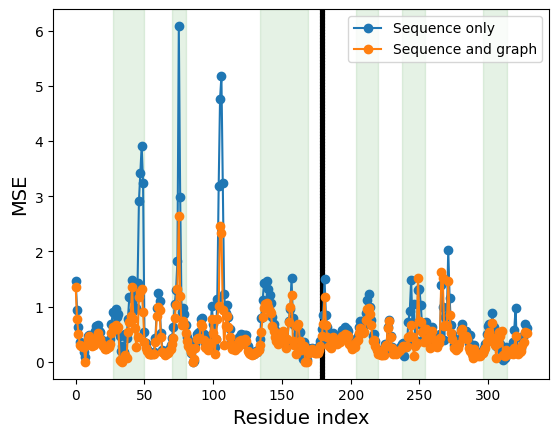

In [3]:
plot_prediction_errors(mse, mse_seq, residue_ids)

## $\Delta_{\mathrm{graph}}$ against different variables

#### CDR vs Framework

<Figure size 640x480 with 0 Axes>

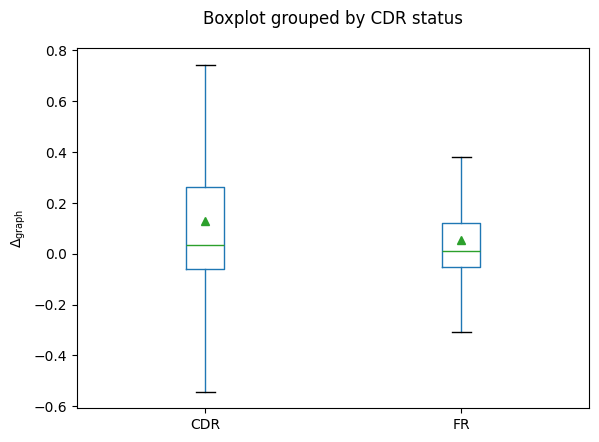

In [4]:
boxplot_delta_graph(delta_graph_v, secondary_v, ind_class='cdr_status')

In [5]:
bootstrap_test(delta_graph_v, secondary_v, ind_class='cdr_status', B=number_bootstraps)

Difference of means between CDR and FR: 0.07570277154445648 (p-value < 1e-06).


In [7]:
bootstrap_test(delta_graph_v, secondary_v, ind_class='cdr_status', B=number_bootstraps, statistic='iqr')

Difference of IQRs between CDR and FR: 0.1503580268472433 (p-value < 1e-06).


In [5]:
bootstrap_test(delta_graph_v, secondary_v, ind_class='cdr_status', B=number_bootstraps, compare_to_zero=True)

Mean for FR vs 0: 0.053902581334114075 (p-value < 1e-06).
Mean for CDR vs 0: 0.12960535287857056 (p-value < 1e-06).


#### Antibody secondary structure

<Figure size 640x480 with 0 Axes>

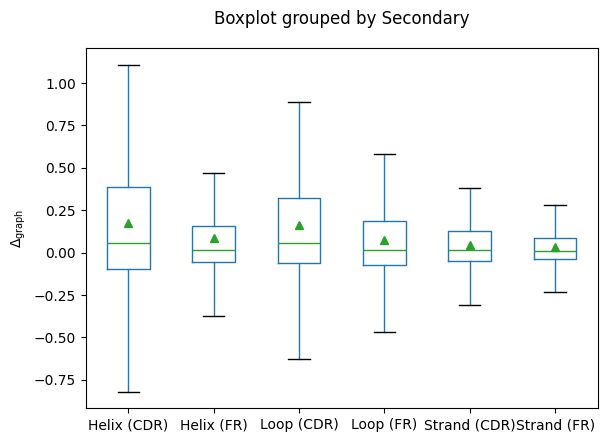

In [8]:
boxplot_delta_graph(delta_graph_v, secondary_v)

In [6]:
bootstrap_test(delta_graph_v, secondary_v, B=number_bootstraps, compare_to_zero=True)

Mean for Helix (FR) vs 0: 0.08645480126142502 (p-value < 1e-06).
Mean for Strand (FR) vs 0: 0.03442015498876572 (p-value < 1e-06).
Mean for Loop (FR) vs 0: 0.07644114643335342 (p-value < 1e-06).
Mean for Helix (CDR) vs 0: 0.17209267616271973 (p-value < 1e-06).
Mean for Strand (CDR) vs 0: 0.04296749830245972 (p-value = 0.000167).
Mean for Loop (CDR) vs 0: 0.15993644297122955 (p-value < 1e-06).


In [8]:
bootstrap_test(delta_graph_v, secondary_v, B=number_bootstraps, all_pairwise=True)
bootstrap_test(delta_graph_v, secondary_v, B=number_bootstraps, statistic='iqr', all_pairwise=True)

Difference of means between Helix (CDR) and Loop (CDR): 0.012156233191490173 (p-value = 0.300623).
Difference of means between Helix (CDR) and Helix (FR): 0.08563787490129471 (p-value = 0.000734).
Difference of means between Helix (CDR) and Loop (FR): 0.0956515297293663 (p-value = 4.2e-05).
Difference of means between Helix (CDR) and Strand (CDR): 0.12912517786026 (p-value = 1e-06).
Difference of means between Helix (CDR) and Strand (FR): 0.1376725137233734 (p-value < 1e-06).
Difference of means between Loop (CDR) and Helix (FR): 0.07348164170980453 (p-value = 7e-06).
Difference of means between Loop (CDR) and Loop (FR): 0.08349529653787613 (p-value < 1e-06).
Difference of means between Loop (CDR) and Strand (CDR): 0.11696894466876984 (p-value < 1e-06).
Difference of means between Loop (CDR) and Strand (FR): 0.12551629543304443 (p-value < 1e-06).
Difference of means between Helix (FR) and Loop (FR): 0.010013654828071594 (p-value = 0.264418).
Difference of means between Helix (FR) and S

#### Antigen secondary structure

<Figure size 640x480 with 0 Axes>

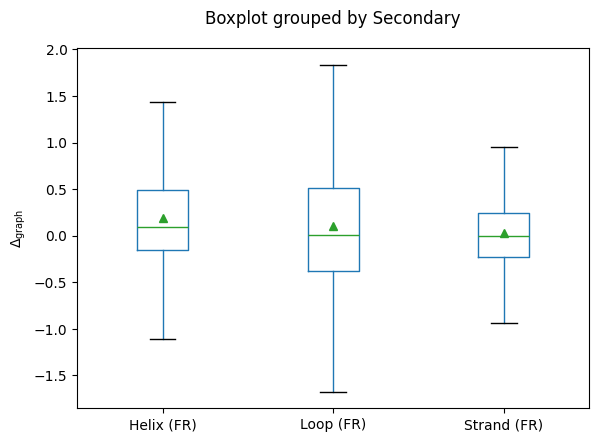

In [10]:
boxplot_delta_graph(delta_graph_ag, secondary_ag)

In [7]:
bootstrap_test(delta_graph_ag, secondary_ag, ind_class='secondary_ag', B=number_bootstraps, compare_to_zero=True)

Mean for Helix vs 0: 0.18516086041927338 (p-value < 1e-06).
Mean for Strand vs 0: 0.02796371467411518 (p-value = 0.238005).
Mean for Loop vs 0: 0.1044636145234108 (p-value = 0.007197).


In [9]:
bootstrap_test(delta_graph_ag, secondary_ag, ind_class='secondary_ag', B=number_bootstraps, all_pairwise=True)
bootstrap_test(delta_graph_ag, secondary_ag, ind_class='secondary_ag', B=number_bootstraps, statistic='iqr', all_pairwise=True)

Difference of means between Helix and Loop: 0.08069724589586258 (p-value = 0.050983).
Difference of means between Helix and Strand: 0.15719714760780334 (p-value = 0.003733).
Difference of means between Loop and Strand: 0.07649990171194077 (p-value = 0.093942).
Difference of IQRs between Loop and Helix: 0.2543036565184593 (p-value = 1e-06).
Difference of IQRs between Loop and Strand: 0.4153403751552105 (p-value < 1e-06).
Difference of IQRs between Helix and Strand: 0.16103671863675117 (p-value = 0.007939).


#### Diversity scores

Low     8763
High    8623
Name: count, dtype: int64


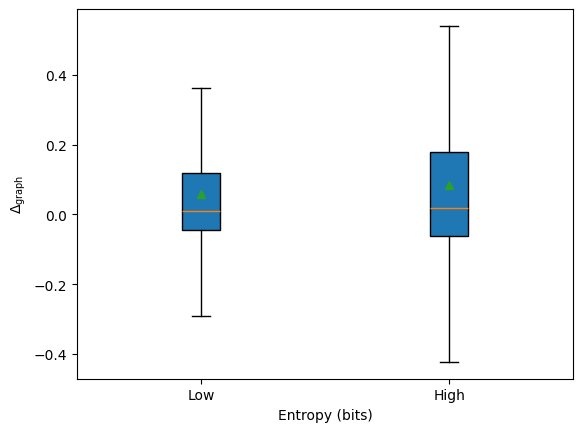

In [4]:
boxplot_delta_graph(delta_graph_v, ds, ind_class='entropy')

In [5]:
bootstrap_test(delta_graph_v, ds, ind_class='entropy', B=number_bootstraps)
bootstrap_test(delta_graph_v, ds, ind_class='entropy', B=number_bootstraps, statistic='iqr')
bootstrap_test(delta_graph_v, ds, ind_class='entropy', B=number_bootstraps, compare_to_zero=True)

Difference of means between High and Low: 0.02804988995194435 (p-value = 3.3e-05).
Difference of IQRs between High and Low: 0.07746144384145737 (p-value < 1e-06).
Mean for Low vs 0: 0.05769925191998482 (p-value < 1e-06).
Mean for High vs 0: 0.08574914187192917 (p-value < 1e-06).


#### Epitope membership

<Figure size 640x480 with 0 Axes>

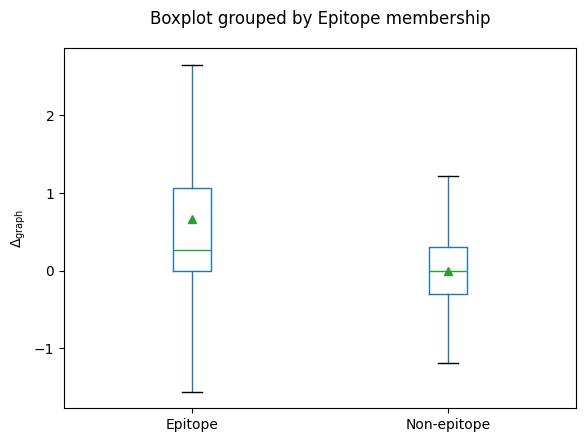

In [12]:
boxplot_delta_graph(delta_graph_ag, epitope_m, ind_class='epitope')

In [13]:
bootstrap_test(delta_graph_ag, epitope_m, ind_class='epitope', B=number_bootstraps)
bootstrap_test(delta_graph_ag, epitope_m, ind_class='epitope', B=number_bootstraps, statistic='iqr')

Difference of means between Epitope and Non-epitope: 0.6645240783691406 (p-value < 1e-06).
Difference of IQRs between Epitope and Non-epitope: 0.4669389072805643 (p-value < 1e-06).


In [8]:
bootstrap_test(delta_graph_ag, epitope_m, ind_class='epitope', B=number_bootstraps, compare_to_zero=True)

Mean for Non-epitope vs 0: 0.001835052971728146 (p-value = 0.464452).
Mean for Epitope vs 0: 0.6663591265678406 (p-value < 1e-06).


#### Paratope membership

<Figure size 640x480 with 0 Axes>

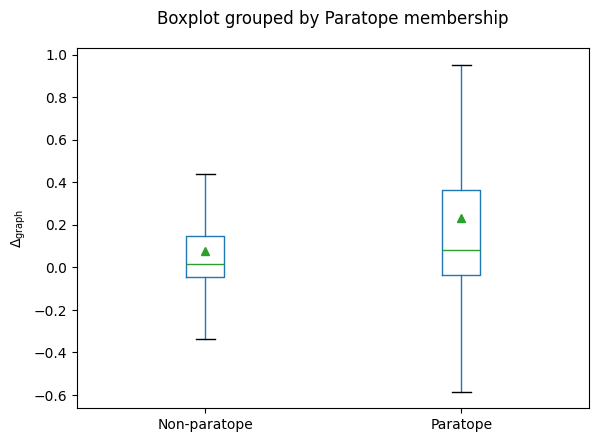

In [14]:
boxplot_delta_graph(delta_graph_v, paratope_m, ind_class='paratope')

In [16]:
bootstrap_test(delta_graph_v, paratope_m, ind_class='paratope', B=number_bootstraps)
bootstrap_test(delta_graph_v, paratope_m, ind_class='paratope', B=number_bootstraps, statistic='iqr')

Difference of means between Paratope and Non-paratope: 0.15364858508110046 (p-value < 1e-06).
Difference of IQRs between Paratope and Non-paratope: 0.2035928824916482 (p-value < 1e-06).


In [9]:
bootstrap_test(delta_graph_v, paratope_m, ind_class='paratope', B=number_bootstraps, compare_to_zero=True)

Mean for Non-paratope vs 0: 0.0769055038690567 (p-value < 1e-06).
Mean for Paratope vs 0: 0.23055408895015717 (p-value < 1e-06).


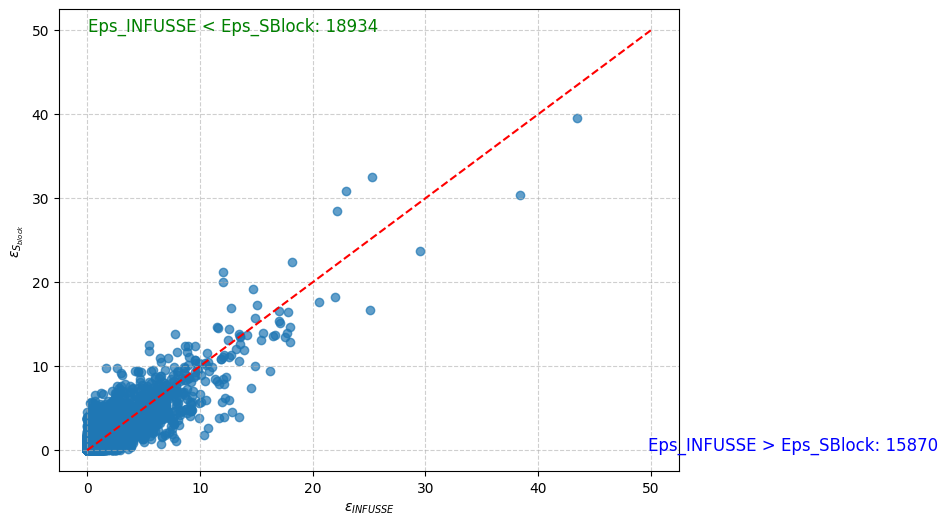

(None, (15870, 18934))

In [19]:
flattened_errors = [item for sublist in errors for item in sublist]
flattened_errors_seq = [item for sublist in errors_seq for item in sublist]
min_val, max_val = 0, 50
# Count points on each side of the identity line
above_identity = sum(1 for e, es in zip(flattened_errors, flattened_errors_seq) if e > es)
below_identity = sum(1 for e, es in zip(flattened_errors, flattened_errors_seq) if e < es)

# Plot with identity line and point counts
plt.figure(figsize=(8, 6))
plt.scatter(flattened_errors, flattened_errors_seq, alpha=0.7, label="Data Points")

# Adding the identity line (y=x)
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1.5, label="Identity (y=x)")

# Annotating the counts
plt.text(min_val + 0.05, max_val - 0.05, f"Eps_INFUSSE < Eps_SBlock: {below_identity}", color="green", fontsize=12)
plt.text(max_val - 0.25, min_val + 0.05, f"Eps_INFUSSE > Eps_SBlock: {above_identity}", color="blue", fontsize=12)

plt.xlabel("$\epsilon_{INFUSSE}$")
plt.ylabel("$\epsilon_{S_{block}}$")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show(), (above_identity, below_identity)


In [20]:
flattened_errors_v = [item for sublist in delta_graph_v for item in sublist]

In [21]:
print((np.sum(flattened_errors_v)))

1245.0334


## Consecutive secondary structure motifs

50 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 50 consecutive helix - FR: 0, CDR: 0, Total: 0
49 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 49 consecutive helix - FR: 0, CDR: 0, Total: 0
48 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 48 consecutive helix - FR: 0, CDR: 0, Total: 0
47 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 47 consecutive helix - FR: 0, CDR: 0, Total: 0
46 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 46 consecutive helix - FR: 0, CDR: 0, Total: 0
45 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 45 consecutive helix - FR: 0, CDR: 0, Total: 0
44 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 44 consecutive helix - FR: 0, CDR: 0, Total: 0
43 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 43 consecutive helix - FR: 0, CDR: 0, Total: 0
42 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 42 consecutive helix 

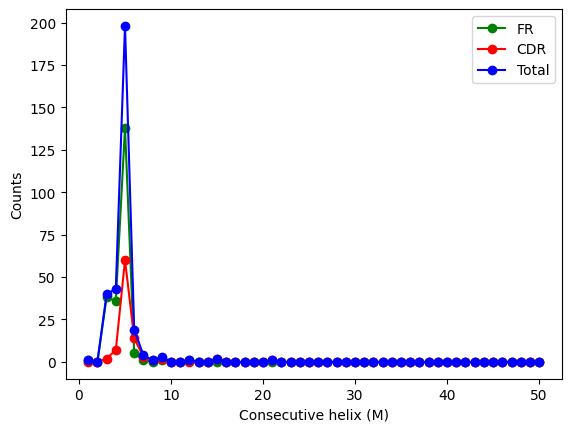

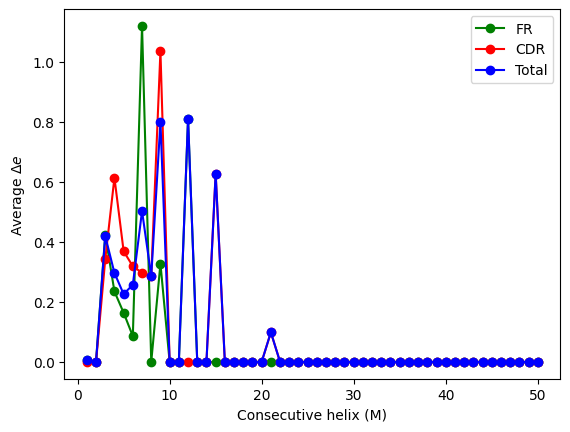

In [16]:
plot_consecutive_secondary(delta_graph_v, secondary_v, max_M=50, secondary_type='helix')